# Beating AES-CBC with Padding Oracle Attack


## Encrypting 48 Bytes
- 세 개의 블록의 평문(PlainText) (아래 그림의 초록색 블록)
- 각 블록은 16 Bytes 크기이다.
- 이들은 암호화(encrypted)되고 세개 블록의 CipherText 로 출력된다.
- 첫 번째 블록은 IV와 XOR 되고 Key 를 통해 암호화된다.
- 각 블록은 이전 블록의 암호문과 XOR 된다.


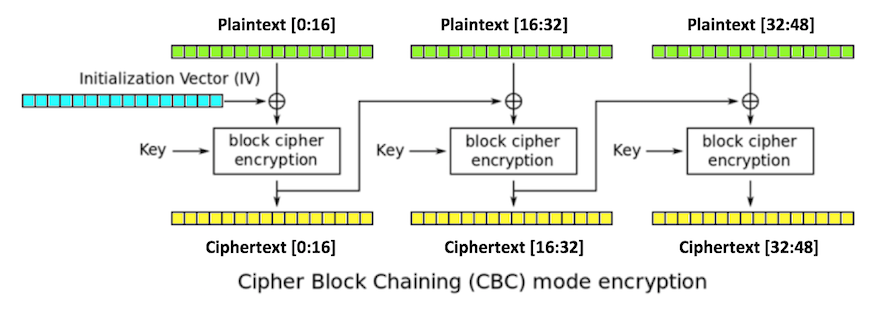

## Encrypting 47 Bytes
만약에, 48 Bytes 가 아닌 47 Bytes 의 평문이 암호화된다고 생각해보자. 이 경우 아래와 같이 보라색의 패딩이 1Byte 추가되어야 한다.

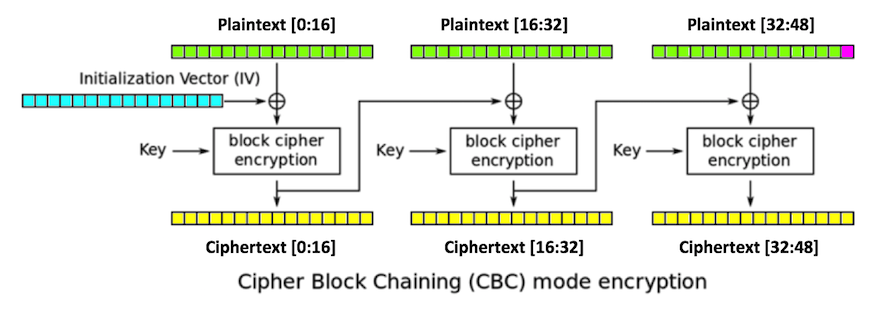

## Decrypting

자 그러면 복호화 되는 과정을 역순으로 살펴보도록 하자.

- 동일한 Key 와 IV 를 사용한다.
- 암호화 블록이 복호화되고 평문이 만들어진다.
- 세번째 블록의 마지막 바이트는 패딩(Padding)이다.

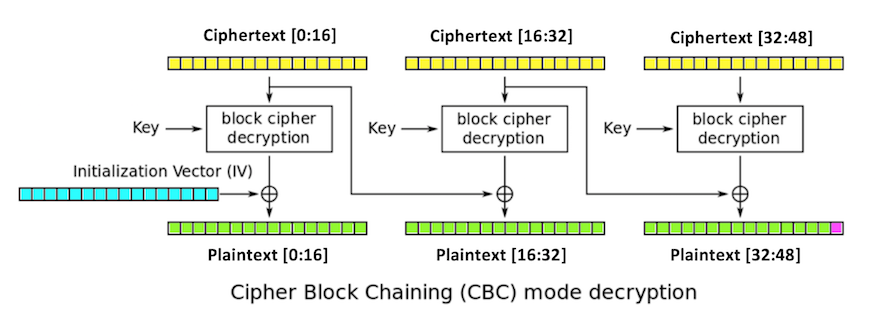

## Padding with PKCS #7

Padding 을 넣기 위한 규칙 중에 가장 흔하게 사용되는 것이 PKCS #7 이다.PKCS#7 은 아래의 규칙으로 동작한다.

- 1 Byte 의 패딩이 필요하다면, 01 을 사용
- 2 Bytes 의 패딩이 필요하다면, 0202 를 사용
- 3 Bytes 의 패딩이 필요하다면, 030303 를 사용
....
- 15 Bytes 의 패딩이 필요하다면, 0f0f0f0f0f0f0f0f0f0f0f0f0f0f0f 를 사용
- 패딩이 필요없다면, chr(16) 문자로 전체 블록을 채우거나 10101010101010101010101010101010 (?)

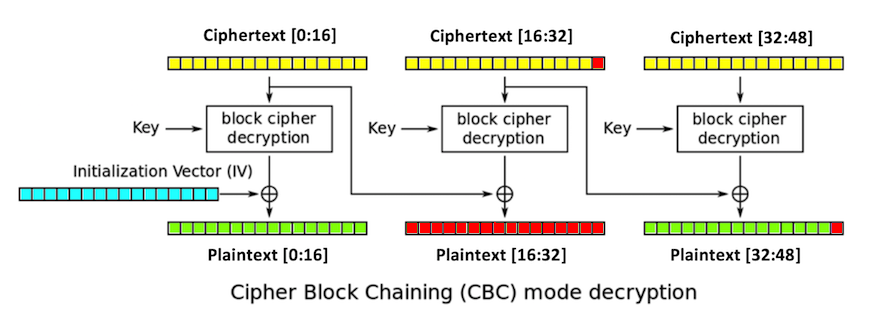


In [1]:
# # Install Requirements
# try:
#     from Crypto.Cipher import AES
# except ModuleNotFoundError:
#     !conda install pycrypto -y
#     !pip install pycryptodome==3.4.3

## IV 와 Key 를 설정

In [1]:
from Crypto.Cipher import AES
key = "0000111122223333"
iv = "aaaabbbbccccdddd"
cipher = AES.new(key, AES.MODE_CBC, iv)
a = "This simple sentence is forty-seven bytes long."

## 패딩 설정

- 패딩설정을 한 뒤에 암호문을 만든다.
- 만들어진 암호문의 32번째 데이터(인덱스상 31)의 데이터를 변경한다.


In [154]:
Ciphertext = cipher.encrypt(a + chr(1))
Mod = Ciphertext[0:31] + bytes([255]) + Ciphertext[32:]

In [155]:
print(Mod[31], Ciphertext[31])

255 164


In [160]:
Mod[31:33]

b'\xff\x13'

In [161]:
Ciphertext[31:33]

b'\xa4\x13'

In [46]:
from difflib import ndiff, SequenceMatcher, Differ
from pprint import pprint
def wrap_sequnce_matcher(func, a, b):
    sm = SequenceMatcher(func, a, b)
    for tag, i1, i2, j1, j2 in sm.get_opcodes():
        print ("%7s a[%d:%d] (%s) b[%d:%d] (%s) \n" % (tag, i1, i2, a[i1:i2], j1, j2, b[j1:j2]))

# list(ndiff(Ciphertext.hex(), Mod.hex()))

In [38]:
wrap_sequnce_matcher(None, Ciphertext.hex(), Mod.hex())

  equal a[0:62] (734484226e124b6dc7881e902cf91c413a3627d72e4c3cc8bbbb94a3f96bba) b[0:62] (734484226e124b6dc7881e902cf91c413a3627d72e4c3cc8bbbb94a3f96bba) 

replace a[62:64] (a7) b[62:64] (ff) 

  equal a[64:96] (08bcc2e29ee63a09f6b1e8713c9f3a2c) b[64:96] (08bcc2e29ee63a09f6b1e8713c9f3a2c) 



In [39]:
wrap_sequnce_matcher(None, cipher.decrypt(Ciphertext).hex(), cipher.decrypt(Mod).hex())

  equal a[0:32] (da77fdb99b619af39e9aaaf57fa9545b) b[0:32] (da77fdb99b619af39e9aaaf57fa9545b) 

 insert a[32:32] () b[32:37] (f4998) 

  equal a[32:33] (6) b[37:38] (6) 

 insert a[33:33] () b[38:48] (49621f8feb) 

  equal a[33:34] (5) b[48:49] (5) 

replace a[34:37] (6e6) b[49:53] (b4ac) 

  equal a[37:38] (3) b[53:54] (3) 

replace a[38:43] (65206) b[54:57] (883) 

  equal a[43:44] (9) b[57:58] (9) 

replace a[44:45] (7) b[58:62] (8da9) 

  equal a[45:46] (3) b[62:63] (3) 

replace a[46:64] (20666f7274792d7365) b[63:64] (b) 

  equal a[64:94] (76656e206279746573206c6f6e672e) b[64:94] (76656e206279746573206c6f6e672e) 

replace a[94:96] (01) b[94:96] (59) 



In [50]:
d = Differ()
pprint(''.join(list(d.compare(cipher.decrypt(Ciphertext).hex(), cipher.decrypt(Mod).hex()))))
# wrap_sequnce_matcher(None, cipher.decrypt(Ciphertext).hex(), cipher.decrypt(Mod).hex())

('  d  a  7  7  f  d  b  9  9  b  6  1  9  a  f  3  9  e  9  a  a  a  f  5  7  '
 'f  a  9  5  4  5  b+ f+ 4+ 9+ 9+ 8  6+ 4+ 9+ 6+ 2+ 1+ f+ 8+ f+ e+ b  5- 6- '
 'e- 6+ b+ 4+ a+ c  3+ 8+ 8+ 3- 6- 5- 2- 0- 6  9- 7+ 8+ d+ a+ 9  3+ b- 2- 0- '
 '6- 6- 6- f- 7- 2- 7- 4- 7- 9- 2- d- 7- 3- 6- 5  7  6  6  5  6  e  2  0  6  '
 '2  7  9  7  4  6  5  7  3  2  0  6  c  6  f  6  e  6  7  2  e- 0- 1+ 5+ 9')


In [41]:
cipher.decrypt(Ciphertext).hex()

'da77fdb99b619af39e9aaaf57fa9545b656e636520697320666f7274792d736576656e206279746573206c6f6e672e01'

In [42]:
cipher.decrypt(Mod).hex()

'da77fdb99b619af39e9aaaf57fa9545bf4998649621f8feb5b4ac388398da93b76656e206279746573206c6f6e672e59'

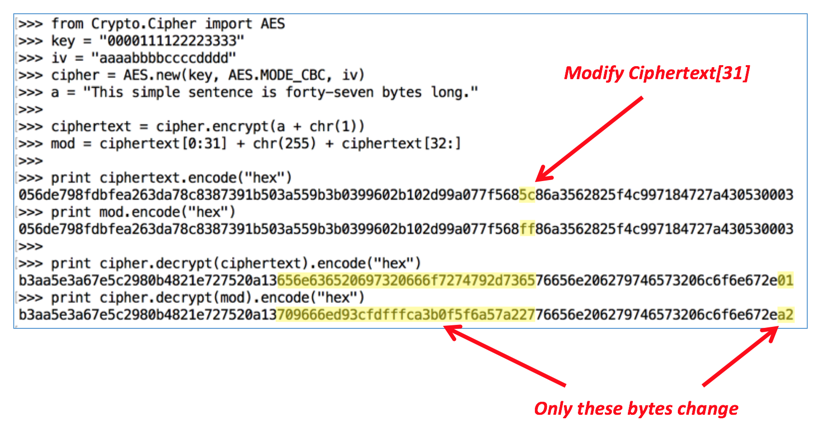

In [224]:
from Crypto.Cipher import AES
key = "aaaabbbbccccdddd"
iv = "1111222233334444"

def decr(ciphertext):
  cipher = AES.new(key, AES.MODE_CBC, iv)
  return ispkcs7(cipher.decrypt(ciphertext))

def ispkcs7(plaintext):
    l = len(plaintext)
    #   c = ord(plaintext[l-1])
#     print(plaintext[l-1])
    c = plaintext[l-1]
#     print(l)
#     print(c)
#     print(bytes([c])*c)
#     print(plaintext[l-c:])
    # print(c)
    if (c > 16) or (c < 1):
        return "PADDING ERROR"
    if plaintext[l-c:] != bytes([c])*c:
        return "PADDING ERROR"
    return plaintext

def encr(plaintext):
  cipher = AES.new(key, AES.MODE_CBC, iv)
  ciphertext = cipher.encrypt(pkcs7(plaintext))
  return ciphertext

def pkcs7(plaintext):
  padbytes = 16 - len(plaintext) % 16
  pad = padbytes * chr(padbytes)
  return plaintext + pad 


In [230]:
a = "This simple sentence is forty-seven bytes long."
print(len(a))
c = encr(a)
print(c.hex())

47
98ca5fbdf748eb1383279754707d91f07ef407da3cb5de765e380a39d9515fea7d0f76e472b8280233ba8feefcd9480a


In [231]:
d = decr(c)
d

b'This simple sentence is forty-seven bytes long.\x01'

In [232]:
mod = c[0:47] + bytes([6])
decr(mod)

'PADDING ERROR'

## Finding Intermediate[47]

Ciphertext[32:] 블록은 Key 를 통해 Decrypt 된 이후에 Ciphertext[16:32] 블록과 Xor 연산되어 Plaintext[32:] 이 만들어진다.

그렇다면 아래와 같이 작성할 수 있다.

`Plaintext[32:47] = Xor(Decrypt(Key,Ciphertext[32:]), Ciphertext[16:32])`

이제부터 `Ciphertext[16:32]` 를 `Intermediate[16:32]` 라고 부를 수 있다고 하자.

취약한 소스는 Padding 오류를 알려주는 함수적 특징이 있다. 따라서, 우리는 복호화 시도를 통한 결과 값을 통해 Padding 오류의 발생을 인지하고 이를 통해 Intermediate 값이 무엇인지를 유추하는 대입 공격을 수행할 수 있다.

In [241]:
def perform_modification(ranger, crypted, target_index):
    intermediate_candiate = list()
    for i in ranger:
        mod = crypted[0:target_index] + bytes([i]) + crypted[target_index+1:]
        result = decr(mod)
        if isinstance(result, bytes):
            print(i, result)
            intermediate_candiate.append(i)
    return intermediate_candiate

In [275]:
def perform_modification_with_prefix(ranger, crypted, target_index, bchar, number_of_bchar, known_chunk):
    intermediate_candiate = list()
    prefix = crypted[0:16] + bchar*number_of_bchar
    print(prefix)
    for i in ranger:
        if known_chunk is not None:
            mod = prefix + bytes([i]) + bytes(known_chunk) + crypted[target_index+1:]
        else:
            mod = prefix + bytes([i]) + crypted[target_index+1:]
        result = decr(mod)
        if isinstance(result, bytes):
            print(i, result)
            intermediate_candiate.append(i)
    return intermediate_candiate

In [235]:
interm = perform_modification(range(256), c, 31)
print(c[31], interm)

234 b'This simple sentence is forty-seven bytes long.\x01'
234 [234]


In [236]:
234 ^ 1

235

In [242]:
a = "This sentence cleaarly says I'M A LOSER."
original = encr(a)
print(original.hex())


2d1f0a1501bdc3afcba6ecafee6695976c446112cdc10f3eb3a4215ae76d0c9a98063703c2a61fd7e399ed27f6ee855b


In [244]:
decr(original)
print(len(a))

40


In [246]:
perform_modification(range(256), original, 31)

147 b'This sentence cl\x04v0\x1a\x1a\xd5\x97\x0eP\xb6\xf9+\xbb\x86\x1adA LOSER.\x08\x08\x08\x08\x08\x08\x08\x01'
154 b"This sentence cleaarly says I'M A LOSER.\x08\x08\x08\x08\x08\x08\x08\x08"


[147, 154]

In [286]:
perform_modification_with_prefix(range(256), original, 31, b'A', 12, [235^4, 102^3 ^ 4, 6^2 ^ 4, 147 ^ 1 ^ 4])

b'-\x1f\n\x15\x01\xbd\xc3\xaf\xcb\xa6\xec\xaf\xeef\x95\x97AAAAAAAAAAAA'
235 b'This sentence cl\x8don_K\xc2\x13md\x9f\n^$Q&9l%l\x1c\xdf\xc5\x1cQ\xfa\xedh\x13\x04\x04\x04\x04'


[235]

In [292]:
interm = [235^4, 102^3, 6^2, 147 ^ 1]

In [300]:
for c, i in zip(list(map(lambda x: ord(x), list("WIN\x01"))), interm):
    print(c^ i)

184
44
74
147


In [303]:
decr(original[0:28] + bytes([c^i for c, i in zip(list(map(lambda x: ord(x), list("WIN\x01"))), interm)]) + original[32:])

b'This sentence cl;}\xbay\x1d\xb1\xd4\x03R\x01\x04\x04\xbb|W\xb3A LOSER.\x08\x08\x08\x08WIN\x01'

## References 
- [samsclass.info](https://samsclass.info/141/proj/p14pad.htm)
- [SequenceMatcher](https://docs.python.org/2/library/difflib.html#difflib.SequenceMatcher.get_opcodes)
- [BogoToGogo : BITS, BYTES, BITSTRING, AND CONSTBITSTREAM](https://www.bogotobogo.com/python/python_bits_bytes_bitstring_constBitStream.php)